In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path

import pickle, os
import scipy


from veloproj import *
from eval_util import *

scv.settings.verbosity = 1
sys.path.insert(1, '../')
import velovae as vv
%load_ext autoreload
%autoreload 2

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '10000', 
                               '--g-rep-dim', '50',
                               '--k-dim', '50',
                               '--data-dir', './retina.h5ad',
                               '--model-name', 'retina_model.cpt',
                               '--exp-name', 'CohAE_retina',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'false',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_tsne',
                               '--vis_type_col', 'Annotation',
                               '--scv_n_jobs', '10',
                               '--v_rg_wt', '0.01' # with low-dimensional velocity constraints, 
                                                   # 1) project a velocity matrix (e.g., by scvelo stochastic mode) 
                                                   # into low-dim space, which was described in
                                                   # our paper https://www.biorxiv.org/content/10.1101/2021.03.19.436127v1.full
                                                   # 2) using low-dim S and U to fit V in the low-dim space using steady-state model
                                                   # make loss to constrain the projected and newly estimated Vs to be similar
                                                   # we currently use smoothl1loss.
                                                   # This parameter weighs this constrain loss.
                              ])
args                   

Namespace(data_dir='./retina.h5ad', model_name='retina_model.cpt', exp_name='CohAE_retina', adata=None, mask_cluster_list=None, use_x=False, fit_offset_train=False, fit_offset_pred=False, use_offset_pred=False, is_half=False, gnn_layer='GAT', use_norm=False, sl1_beta=1.0, v_rg_wt=0.01, n_nb_newadata=30, scv_n_jobs=10, refit=True, output='./', vis_key='X_tsne', vis_type_col='Annotation', z_dim=100, n_conn_nb=30, g_rep_dim=50, h_dim=256, k_dim=50, conv_thred=1e-06, n_epochs=10000, lr=1e-05, weight_decay=0.0, seed=42, log_interval=100, device='cuda:2', gumbsoft_tau=5.0, aux_weight=1.0, nb_g_src='SU', ld_nb_g_src='SU', n_raw_gene=2000, lr_decay=0.9, ld_adata='projection.h5')

In [3]:
adata = sc.read_h5ad('retina1_out1.h5ad')
adata

AnnData object with n_obs × n_vars = 2726 × 2000
    obs: 'Clusters', 'Annotation', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'vae_time', 'vae_std_t', 'vae_t0'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s'
    uns: 'Annotation_colors', 'neighbors', 'pca', 'vae_run_time', 'vae_test_idx', 'vae_train_idx'
    obsm: 'X_pca', 'X_umap', 'vae_std_z', 'vae_z'
    varm: 'PCs', 'vae_mode'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'vae_rho', 'vae_s0', 'vae_shat', 'vae_u0', 'vae_uhat', 'vae_velocity', 'vae_velocity_u'
    obsp: 'connectivities', 'distances'

In [4]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [5]:
cluster_edges = [
    ("Progenitor", "Neuroblast"), 
    ("Neuroblast", "AC/HC"), 
    ("Neuroblast", "RGC"), 
    ("Neuroblast", "PR"), 
    ]
EXP_NAME = args.exp_name
exp_metrics = {}

In [6]:
sc.tl.tsne(adata)

In [7]:
scv.tl.velocity_graph(adata, vkey='vae_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata,vkey='vae_velocity')

  0%|          | 0/2726 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_vae_tsne_retina.png


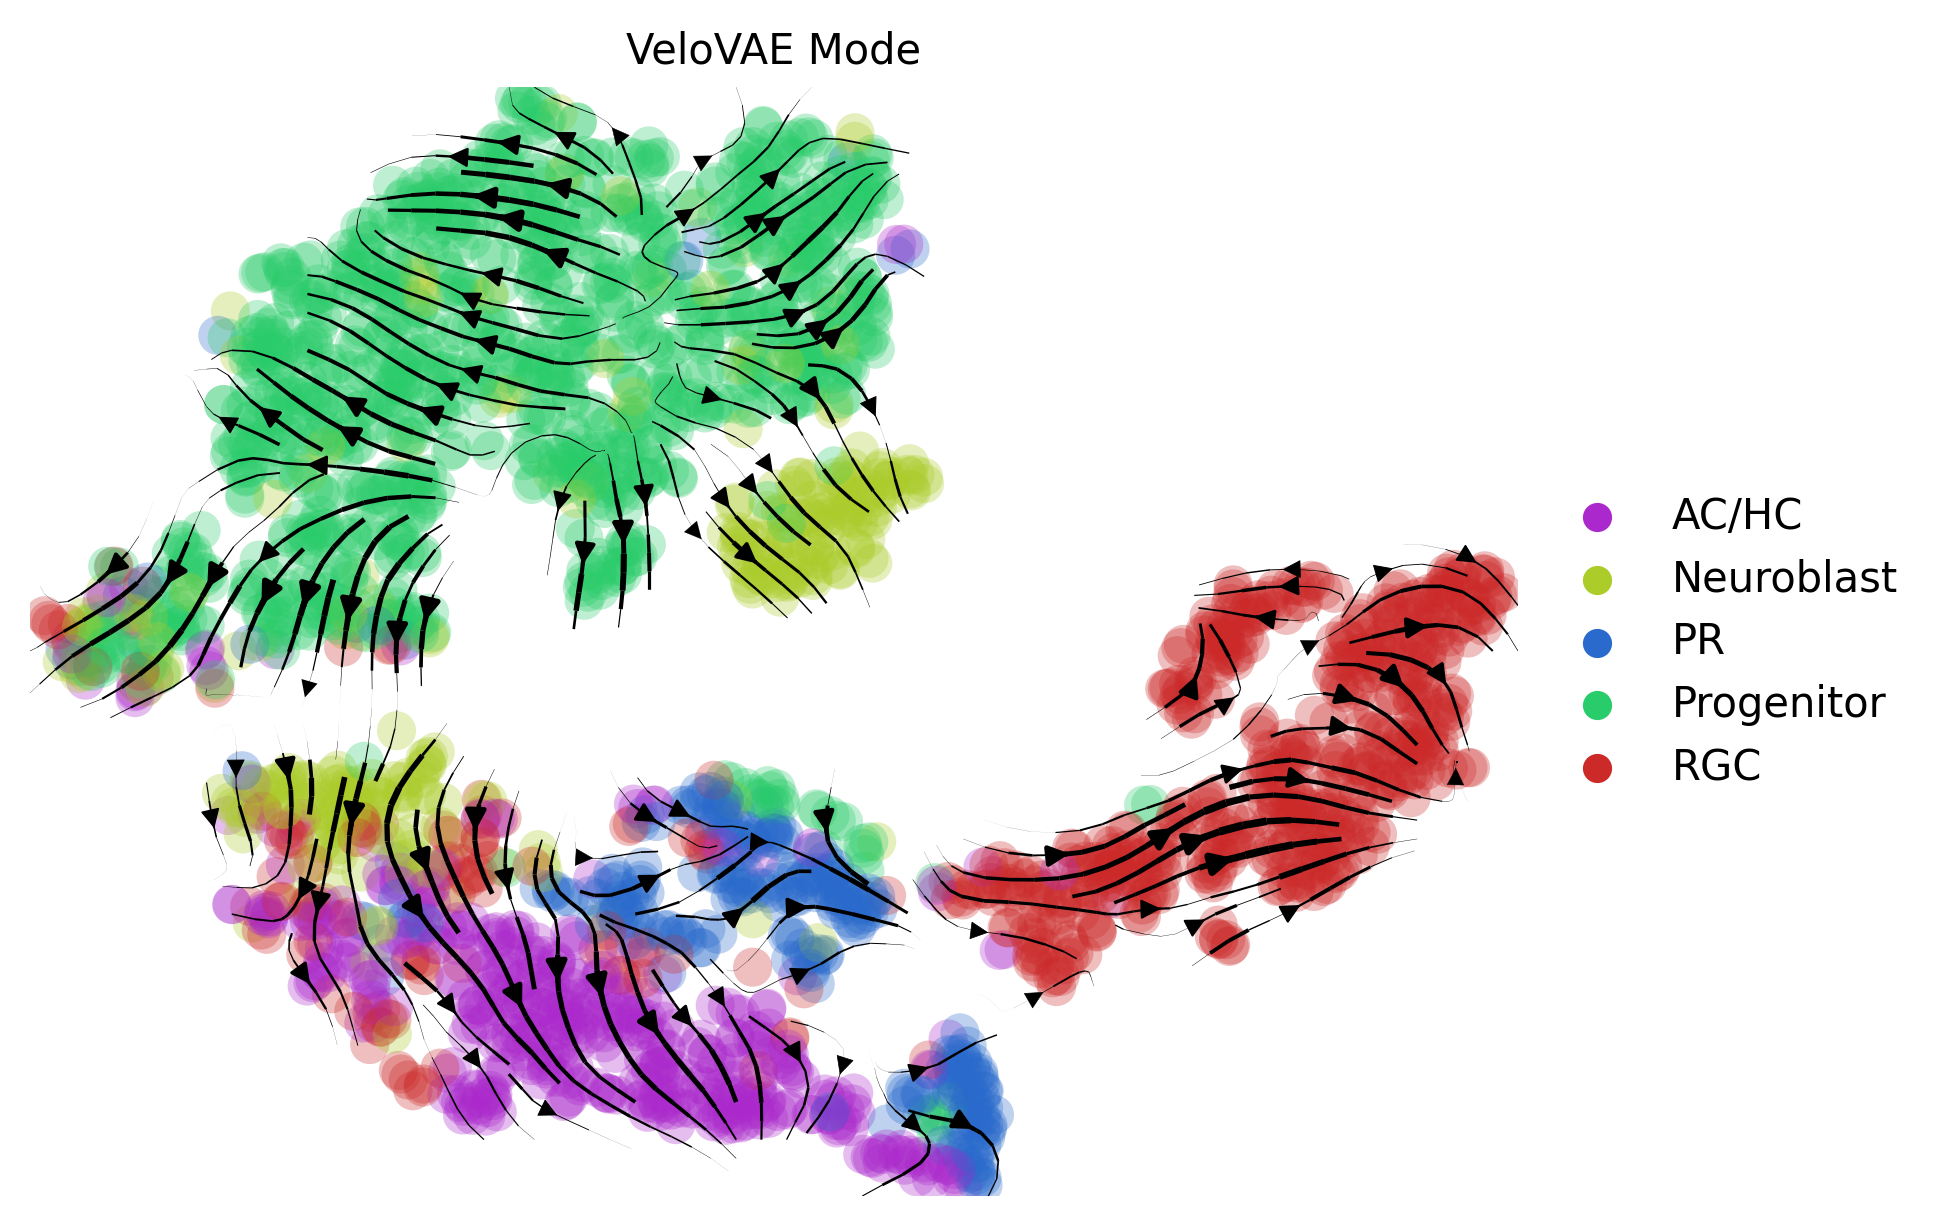

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.20034765, ('Neuroblast', 'AC/HC'): 0.18959166, ('Neuroblast', 'RGC'): 0.17518349, ('Neuroblast', 'PR'): 0.11929102}
Total Mean: 0.17110344767570496
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.701834347663907, ('Neuroblast', 'AC/HC'): 0.6099635993802776, ('Neuroblast', 'RGC'): 0.6296622503377804, ('Neuroblast', 'PR'): 0.5328981161419155}
Total Mean: 0.6185895783809701
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): -0.019525359416963997, ('Neuroblast', 'AC/HC'): 0.4388896822985055, ('Neuroblast', 'RGC'): 0.4157094637142215, ('Neuroblast', 'PR'): 0.31855064176582987}
Total Mean: 0.2884061070903982
# In-cluster Coherence
{'AC/HC': 0.8125779526641195, 'Neuroblast': 0.7975292152493094, 'PR': 0.8201467031646483, 'Progenitor': 0.8015801031870167, 'RGC': 0.833366616449106}
Total Mean: 0.81304011814284
# In-cluster Confidence
{'AC/HC': 0.7764427514524225, 'Neuro

In [8]:
scv.pl.velocity_embedding_stream(adata, legend_loc="right margin", 
                                 vkey='vae_velocity',
                                 basis=args.vis_key, 
                                 color=args.vis_type_col,
                                 dpi=300, title='VeloVAE Mode',
                                save='vae_tsne_retina.png')
exp_metrics["VeloVE"] = evaluate(adata, cluster_edges, args.vis_type_col, 'vae_velocity',x_emb=args.vis_key)